# i2b2 export analysis (v3)
case=708, control=99791

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data

In [3]:
# CASE
cases = pd.read_csv("exports/v3/case/casehendx_patient_demographics_RDALEJ_NO_PHI_65669_1.csv")
print("cases:",cases.shape)
# CONTROL
controls = pd.read_csv("exports/v3/control/CTRLHENDRX_patient_demographics_RDALEJ_NO_PHI_65679_1.csv")
print("controls:",controls.shape)
print("% cases:", cases.shape[0]/(controls.shape[0]+cases.shape[0]))

cases: (708, 19)
controls: (99791, 19)
% cases: 0.007044846217375297


In [4]:
# peek
cases[1:5]

,MASTER_REQUEST_ID,QUERY_NAME,DE_ID,BIRTH_DATE,GENDER,STATE,ZIP,COUNTRY,CITY,COUNTY,MARITAL_STATUS,RACE,ETHNIC_GROUP,LANGUAGE,RELIGION,LIVING_WILL,DECEASED,DECEASED_DATE,CURRENT_AGE
1,65669,Standard Data Request 65669 on 09/11/2023 14:2...,3929980373,09/10/1953 12:00:00 AM,M,AL,36027,US,EUFAULA,Barbour,Married,Black or African American,Non-Hispanic/Latino,English,Baptist,Unknown,NaN,NaN,70.0
2,65669,Standard Data Request 65669 on 09/11/2023 14:2...,3928658953,11/01/1991 12:00:00 AM,F,AL,35214,US,BIRMINGHAM,Jefferson,Single,Black or African American,Non-Hispanic/Latino,English,None,Unknown,NaN,NaN,31.0
3,65669,Standard Data Request 65669 on 09/11/2023 14:2...,3923618228,12/20/1949 12:00:00 AM,M,AL,35226,US,BIRMINGHAM,Jefferson,Married,White,Non-Hispanic/Latino,English,Catholic,Power of Attorney,NaN,NaN,73.0
4,65669,Standard Data Request 65669 on 09/11/2023 14:2...,3928772116,09/08/1961 12:00:00 AM,F,AL,36732,US,DEMOPOLIS,Marengo,Married,White,Non-Hispanic/Latino,English,Methodist,Both,Y,12/12/2014 12:00:00 AM,NaN


# Code data for analysis
  * convert strings to binary integers
  * remove missing values
  * split into training and test

Merge case and control data frames, introducing the classification variable "SICK", which is 0 for "venous catheter, no infection" and 1 for "venous catheter infection"

We also "balance" the case/control, by subsampling the controls to 35k, so that cases are around 2% of the population, as we read that's recommended for classifier training. 

## subset controls

In [5]:
#
# merge and subset controls to 7k

# SUBSET controls
from sklearn.utils import resample
controlsSubset = resample(controls,n_samples=35000)
print("controls              dims:", controls.shape)
print("case % before subsampling :", cases.shape[0]/(controls.shape[0]+cases.shape[0]))
print("controls (subsampled) dims:", controlsSubset.shape)
print("case % after subsampling  :", cases.shape[0]/(controlsSubset.shape[0]+cases.shape[0]))


controls              dims: (99791, 19)
case % before subsampling : 0.007044846217375297
controls (subsampled) dims: (35000, 19)
case % after subsampling  : 0.019827489638176318


## merge case/control and add classification variable "SICK"

In [6]:
#
# Add TARGET column
# 
caseSick = cases.copy()
caseSick["SICK"] = 1
print("caseSick",caseSick.shape)
controlSick = controlsSubset.copy()
controlSick["SICK"] = 0
print("controlSick", controlSick.shape)
caseControlSick =pd.concat([caseSick, controlSick])

print("caseControlSick",caseControlSick.shape)

caseSick (708, 20)
controlSick (35000, 20)
caseControlSick (35708, 20)


# code & clean data for analysis 
convert strings to integers, remove patients with missing data

## remove missing data (NaN's)

In [7]:
#
# remove NANs
#
goodRows = np.logical_not(
    # bad rows
    np.logical_or(
        np.logical_or(
            caseControlSick["MARITAL_STATUS"].isna(),
            caseControlSick["GENDER"].isna()
        ),
        np.logical_or(
            caseControlSick["RACE"].isna(),
            caseControlSick["ZIP"].isna()
        )
    )
)
print("GoodRows:",sum(goodRows))
 # clean
caseControlSickOk=caseControlSick.loc[goodRows]
print("removed ",caseControlSick.shape[0]-caseControlSickOk.shape[0])
print("caseControlSickOk", caseControlSickOk.shape)
#
# double check
# 
print("NaN scan:")
for f in caseControlSickOk.columns:
    print("\t",f,":",sum(caseControlSickOk[f].isna()))

GoodRows: 35696
removed  12
caseControlSickOk (35696, 20)
NaN scan:
	 MASTER_REQUEST_ID : 0
	 QUERY_NAME : 0
	 DE_ID : 0
	 BIRTH_DATE : 0
	 GENDER : 0
	 STATE : 0
	 ZIP : 0
	 COUNTRY : 0
	 CITY : 1
	 COUNTY : 315
	 MARITAL_STATUS : 0
	 RACE : 0
	 ETHNIC_GROUP : 1264
	 LANGUAGE : 0
	 RELIGION : 3
	 LIVING_WILL : 468
	 DECEASED : 25967
	 DECEASED_DATE : 26011
	 CURRENT_AGE : 9685
	 SICK : 0


##  convert to categorical data

In [8]:
#
# convert categorical to numeric
#
# gives "SettingWithCopyWarning", but seems to work anyways??

# code race
blackRows = caseControlSickOk["RACE"]=="Black or African American"
caseControlSickOk.loc[blackRows,"RACE_FEATURE"]=1
whiteRows = caseControlSickOk["RACE"]=="White"
caseControlSickOk.loc[whiteRows,"RACE_FEATURE"]=0
# code gender
maleRows = caseControlSickOk["GENDER"]=="M"
caseControlSickOk.loc[maleRows,"GENDER_FEATURE"]=0
femaleRows = caseControlSickOk["GENDER"]=="F"
caseControlSickOk.loc[femaleRows,"GENDER_FEATURE"]=1

# remove other races and genders
codedRows=np.logical_and(np.logical_or(blackRows,whiteRows),np.logical_or(maleRows,femaleRows))
print("caseControlSickOk", caseControlSickOk.shape)
print("size",codedRows.size)
print("sum",sum(codedRows))
print("sums race",sum(whiteRows), sum(blackRows), sum(whiteRows)+sum(blackRows), 
     sum(np.logical_or(whiteRows,blackRows)))
print("sums gender",sum(maleRows), sum(femaleRows), sum(maleRows)+sum(femaleRows), 
     sum(np.logical_or(maleRows,femaleRows)))

caseControlSickOKCoded=caseControlSickOk.loc[codedRows]
print("caseControlSickOKCoded",caseControlSickOKCoded.shape)

caseControlSickOk (35696, 22)
size 35696
sum 33349
sums race 22486 10863 33349 33349
sums gender 19083 16613 35696 35696
caseControlSickOKCoded (33349, 22)


/scratch/local/ipykernel_107238/344313266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caseControlSickOk.loc[blackRows,"RACE_FEATURE"]=1
/scratch/local/ipykernel_107238/344313266.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caseControlSickOk.loc[maleRows,"GENDER_FEATURE"]=0


In [9]:
#
# convert MARITAL_STATUS to mulitple (boolean) features
#
dataClassDf=pd.get_dummies(caseControlSickOKCoded, 
                             columns=["MARITAL_STATUS"], 
                             drop_first=True)

# remove columns we don't want


dataClassDf = dataClassDf[
    ["RACE_FEATURE","GENDER_FEATURE","ZIP",
     'MARITAL_STATUS_Life Partner', 'MARITAL_STATUS_Married', 'MARITAL_STATUS_Separated', 'MARITAL_STATUS_Single', 'MARITAL_STATUS_Unknown', 'MARITAL_STATUS_Widowed',
     "SICK"]]


print("dataClassDf.names:",dataClassDf.columns.tolist())

print("caseControlSickOKCoded dims", caseControlSickOKCoded.shape)
print("dataClassDf            dims", caseControlSickOKCoded.shape)

dataClassDf.names: ['RACE_FEATURE', 'GENDER_FEATURE', 'ZIP', 'MARITAL_STATUS_Life Partner', 'MARITAL_STATUS_Married', 'MARITAL_STATUS_Separated', 'MARITAL_STATUS_Single', 'MARITAL_STATUS_Unknown', 'MARITAL_STATUS_Widowed', 'SICK']
caseControlSickOKCoded dims (33349, 22)
dataClassDf            dims (33349, 22)


## re-visualize

### RACE

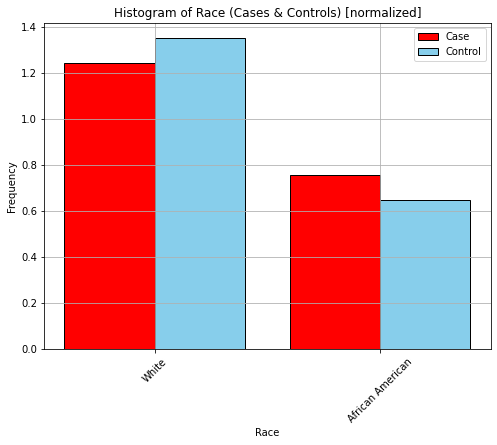

In [10]:
#
# plot both on same chart. 
#
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(
 #   [x[x["RACE_FEATURE"]==1]["SICK"],x[x["RACE_FEATURE"]==0]["SICK"]], label=["AA","CA"],
    [
        dataClassDf[dataClassDf["SICK"]==1]["RACE_FEATURE"],
        dataClassDf[dataClassDf["SICK"]==0]["RACE_FEATURE"]
    ], 
    label=["Case","Control"],
    color=['red','skyblue'] ,
    edgecolor='black', 
    bins=2,
    density=True  # normalize
)

plt.xlabel("Race")
plt.xticks(ticks=[0.25,0.75],labels=["White","African American"], rotation=45)
plt.ylabel('Frequency')
plt.title(f'Histogram of Race (Cases & Controls) [normalized]')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### GENDER

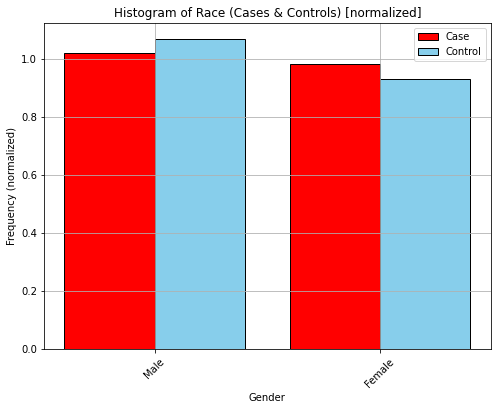

In [11]:
#
# plot both on same chart. 
#
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(
    [
        dataClassDf[dataClassDf["SICK"]==1]["GENDER_FEATURE"],
        dataClassDf[dataClassDf["SICK"]==0]["GENDER_FEATURE"]
    ], 
    label=["Case","Control"],
    color=['red','skyblue'] ,
    edgecolor='black', 
    bins=2,
    density=True  # normalize
)

plt.xlabel("Gender")
plt.xticks(ticks=[0.25,0.75],labels=["Male","Female"], rotation=45)
plt.ylabel('Frequency (normalized)')
plt.title(f'Histogram of Race (Cases & Controls) [normalized]')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### Marital Status

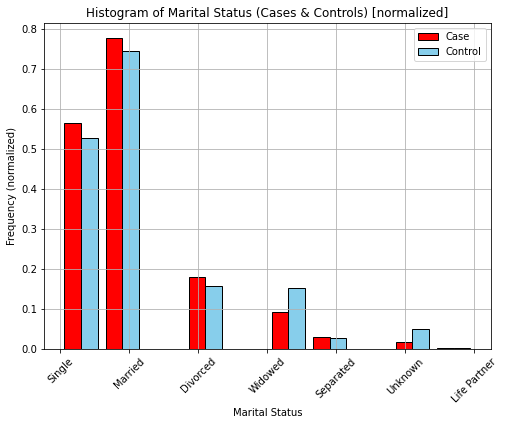

In [12]:
#
# cheating a bit - going back before spliting each status into it's own feature
#
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(
    [
        caseControlSickOk[caseControlSickOk["SICK"]==1]["MARITAL_STATUS"],
        caseControlSickOk[caseControlSickOk["SICK"]==0]["MARITAL_STATUS"]
    ], 
    label=["Case","Control"],
    color=['red','skyblue'] ,
    edgecolor='black', 
    #bins=2,
    density=True  # normalize
)

plt.xlabel("Marital Status")
plt.xticks(rotation=45)
plt.ylabel('Frequency (normalized)')
plt.title(f'Histogram of Marital Status (Cases & Controls) [normalized]')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### Zip Code
This really needs a scatter plot of case vs control counts per zip....

In [13]:
dataClassDf["ZIP"].value_counts()

35215.0    661
35211.0    540
35020.0    435
35242.0    374
35214.0    344
          ... 
38632.0      1
49858.0      1
33712.0      1
35662.0      1
33069.0      1
Name: ZIP, Length: 1730, dtype: int64

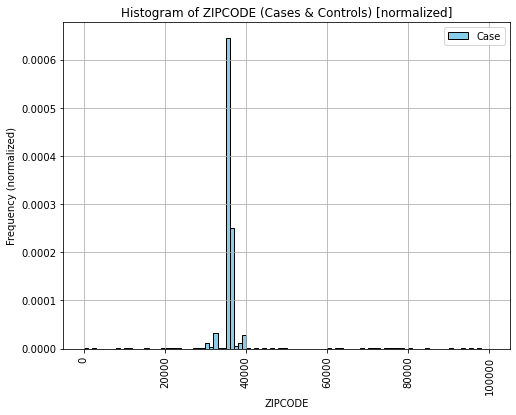

In [17]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(
    dataClassDf["ZIP"], 
    label=["Case","Control"],
    color='skyblue' ,
    edgecolor='black', 
    bins=100,
    density=True  # normalize
)

plt.xlabel("ZIPCODE")
plt.xticks(rotation=90)#ticks=[0.25,0.75],labels=["Male","Female"])
plt.ylabel('Frequency (normalized)')
plt.title(f'Histogram of ZIPCODE (Cases & Controls) [normalized]')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

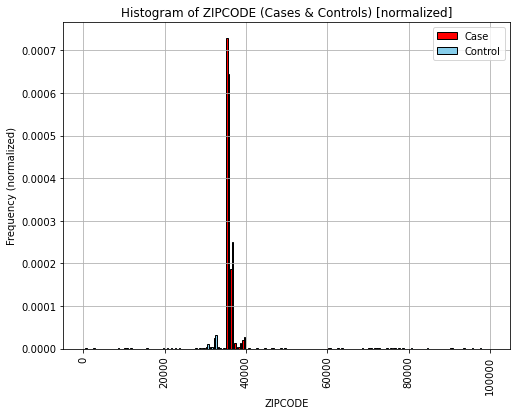

In [14]:
#
# plot both on same chart. 
#
zips3500 = dataClassDf[np.logical_and(dataClassDf["ZIP"]>35000,dataClassDf["ZIP"]<35200)]
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(
    [
        dataClassDf[dataClassDf["SICK"]==1]["ZIP"],
        dataClassDf[dataClassDf["SICK"]==0]["ZIP"]
    ], 
    label=["Case","Control"],
    color=['red','skyblue'] ,
    edgecolor='black', 
    bins=100,
    density=True  # normalize
)

plt.xlabel("ZIPCODE")
plt.xticks(rotation=90)#ticks=[0.25,0.75],labels=["Male","Female"])
plt.ylabel('Frequency (normalized)')
plt.title(f'Histogram of ZIPCODE (Cases & Controls) [normalized]')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

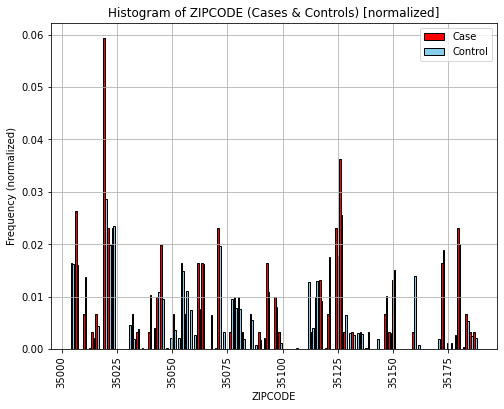

In [28]:
#
# plot both on same chart. 
#
zips3500 = dataClassDf[np.logical_and(dataClassDf["ZIP"]>35000,dataClassDf["ZIP"]<35200)]
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(
    [
        zips3500[zips3500["SICK"]==1]["ZIP"],
        zips3500[zips3500["SICK"]==0]["ZIP"]
    ], 
    label=["Case","Control"],
    color=['red','skyblue'] ,
    edgecolor='black', 
    bins=100,
    density=True  # normalize
)

plt.xlabel("ZIPCODE")
plt.xticks(rotation=90)#ticks=[0.25,0.75],labels=["Male","Female"])
plt.ylabel('Frequency (normalized)')
plt.title(f'Histogram of ZIPCODE (Cases & Controls) [normalized]')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

## Format data for ML

In [49]:
# convert our dataFrame to a numpy array of integers
feature_names=dataClassDf.columns.tolist()[:-1]
print("feature_names:",feature_names)
# test on 3 rows
#x[feature_names][0:3].astype('int')
#data = np.array(x[x.columns.tolist()[:-1]][0:3].astype('int'))
data = np.array(dataClassDf[feature_names].astype('int'))
data[0:3]
print("dataClassDf dims", dataClassDf.shape)

feature_names: ['RACE_FEATURE', 'GENDER_FEATURE', 'ZIP', 'MARITAL_STATUS_Life Partner', 'MARITAL_STATUS_Married', 'MARITAL_STATUS_Separated', 'MARITAL_STATUS_Single', 'MARITAL_STATUS_Unknown', 'MARITAL_STATUS_Widowed']
dataClassDf dims (33188, 10)


In [31]:
# build Bunch data dictionary for analysis
from sklearn.utils import Bunch

ds = Bunch(data=data,target=dataClassDf["SICK"].astype('int'),feature_names=feature_names)

ds

{'data': array([[    1,     0, 36083, ...,     1,     0,     0],
        [    1,     0, 36027, ...,     0,     0,     0],
        [    1,     1, 35214, ...,     1,     0,     0],
        ...,
        [    1,     0, 35115, ...,     1,     0,     0],
        [    1,     0, 35235, ...,     0,     0,     0],
        [    0,     0, 36066, ...,     0,     0,     0]]),
 'target': 0        1
 1        1
 2        1
 3        1
 4        1
         ..
 32489    0
 24480    0
 97666    0
 23801    0
 74973    0
 Name: SICK, Length: 33188, dtype: int64,
 'feature_names': ['RACE_FEATURE',
  'GENDER_FEATURE',
  'ZIP',
  'MARITAL_STATUS_Life Partner',
  'MARITAL_STATUS_Married',
  'MARITAL_STATUS_Separated',
  'MARITAL_STATUS_Single',
  'MARITAL_STATUS_Unknown',
  'MARITAL_STATUS_Widowed']}

In [35]:
label_names = ["Sick","Healthy"]
labels = ds['target']
feature_names = ds['feature_names']
features = ds['data']

## Try logistical regression

In [34]:
# load libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### split into train/test

In [57]:
#
# split to training and test subsets
#
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size = 0.40, 
                                                          random_state = 42)
print("data dims ", data.shape)
print("train dims", train.shape)
print("test dims ", test.shape)



data dims  (33188, 9)
train dims (19912, 9)
test dims  (13276, 9)


### build model, train

In [ ]:
# Initialize the logistic regression model
logistic_reg = LogisticRegression()

# Fit the model to the training data
logistic_reg.fit(train, train_labels)

### predict

infection predictions:  0 int64


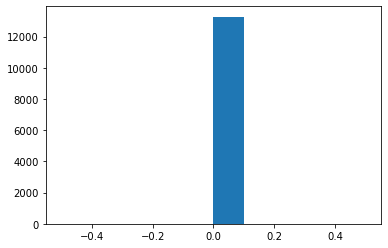

In [61]:
preds=logistic_reg.predict(test)

print("infection predictions: ", sum(preds==True), preds.dtype)
plt.figure()
plt.hist(preds)
plt.show()
#clf.predict_proba(X[:2, :])

#clf.score(X, y)

### interogate predictions

In [62]:
### does this make sense for logistic Reg
# Make predictions on the test set
preds = logistic_reg.predict(test)

# Evaluate the model
accuracy = accuracy_score(test, preds)
confusion = confusion_matrix(test, preds)
classification_rep = classification_report(test, preds)

# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets